### 导入数据

依然采用之前的数据，使用pandas库进行导入。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Time\ Series\ Forecasting

/content/drive/MyDrive/Time Series Forecasting


在预处理部分，`1. Data Processing.ipynb`中有详细的操作，这里就不一一介绍了。

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,01/01/2007,NaN,-26.68,-25.95,NaN,NaN,-29918.592,NaN
1,01/01/2008,NaN,-31.22,-30.45,NaN,NaN,-26686.368,NaN
2,01/01/2009,0.0,-31.96,-31.14,5.2,4.9,-24530.688,2.4
3,01/01/2010,26.5,-29.78,-29.08,8.3,7.9,-25730.784,3.1
4,01/01/2011,0.0,-25.56,-24.82,5.6,5.5,-28958.688,2.5


In [4]:
# 去除缺失值
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# 只保留一列地下水数据
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [5]:
# 简化列名
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']
targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,01/01/2010,26.5,-29.08,8.3,-25730.784,3.1
2,01/01/2011,0.0,-24.82,5.6,-28958.688,2.5
3,01/01/2012,0.0,-27.27,1.5,-35187.264,2.0
4,01/01/2013,0.0,-30.81,1.6,-28532.736,2.5


In [6]:
from datetime import datetime, date 

df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')

In [7]:
# 对时间戳排序
df = df.sort_values(by='Date')

# 检查时间间隔
df['Time_Interval'] = df.Date - df.Date.shift(1)
print(f"{df['Time_Interval'].value_counts()}")
df = df.drop('Time_Interval', axis=1)

1 days    4198
Name: Time_Interval, dtype: int64


In [8]:
# 对缺失值进行处理
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

这部分之前都与`1. Data Processing.ipynb`中完全一致。

由于Transformer等深度学习的方法需要较多的训练数据，因而在这里不再对其进行下采样，否则数据量太少。之前的预处理过的数据是经过下采样的，不能直接拿来使用，因而在这里重新对数据进行预处理。

In [9]:
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
138,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
276,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
414,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
552,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


### Transformer模型的构建

#### Positional Encoder

In [10]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]   

#### Transformer Model

In [11]:
class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

### 数据的处理

In [40]:
# 超参数
input_window = 10
output_window = 1
batch_size = 32
train_size = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def create_inout_sequences(input_data, input_window ,output_window):
    inout_seq = []
    L = len(input_data)
    block_len = input_window + output_window
    block_num =  L - block_len + 1

    for i in range( block_num ):
        train_seq = input_data[i : i + input_window]
        train_label = input_data[i + output_window : i + input_window + output_window]
        inout_seq.append((train_seq ,train_label))

    return torch.FloatTensor(np.array(inout_seq))

划分训练集和测试集

In [14]:
def get_data(data, split):
    series = data["Depth_to_Groundwater"].values

    from sklearn.preprocessing import MinMaxScaler
    
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    series = scaler.fit_transform(series.reshape(-1, 1)).reshape(-1)
    
    split = int(split*len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_sequence = create_inout_sequences(train_data, input_window, output_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data, input_window, output_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

划分batch

In [15]:
def get_batch(input_data, i, batch_size):
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[i:i+batch_len]
    input = torch.stack([item[0] for item in data]).view((input_window,batch_len,1))
    target = torch.stack([item[1] for item in data]).view((input_window,batch_len,1))
    return input, target

### 训练

In [18]:
def train(model, train_data, loss_function, optimizer):
    model.train()
    total_loss = 0.

    for i in range(0, len(train_data), batch_size):
        data, targets = get_batch(train_data, i, batch_size)
        output = model(data)
        loss = loss_function(output, targets)

        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
    
    num_batches = len(train_data) // batch_size
    avg_loss = total_loss / num_batches

    print(f"Train loss: {avg_loss}")

In [17]:
def test(model, test_data, loss_function):
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, len(test_data), batch_size):
            data, targets = get_batch(test_data, i, batch_size)
            output = model(data)            
            total_loss += len(data[0]) * loss_function(output, targets).item()
    num_batches = len(test_data) // batch_size
    avg_loss = total_loss / num_batches
    
    print(f"Test loss: {avg_loss}")

In [41]:
train_data, val_data = get_data(df, 0.8)

lr = 1e-5

model = TransAm().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [42]:
n_epoch = 100
train_loss = []
test_loss = []
for epoch in range(n_epoch):
  print(f"------------epoch:{epoch+1}------------")
  train(model, train_data, criterion, optimizer)
  test(model, train_data, criterion)

------------epoch:1------------
Train loss: 0.12812888328559124
Test loss: 1.770352682018151
------------epoch:2------------
Train loss: 0.06885894133637731
Test loss: 1.376780311872538
------------epoch:3------------
Train loss: 0.05715346599642474
Test loss: 1.7387123310293715
------------epoch:4------------
Train loss: 0.05684700269753543
Test loss: 1.920842777136176
------------epoch:5------------
Train loss: 0.05321035319222854
Test loss: 1.9225129563755428
------------epoch:6------------
Train loss: 0.049038691696925804
Test loss: 1.8434512878235323
------------epoch:7------------
Train loss: 0.0469265328362011
Test loss: 1.7238902416295157
------------epoch:8------------
Train loss: 0.04308417890794002
Test loss: 1.5522139683867304
------------epoch:9------------
Train loss: 0.038681726840038136
Test loss: 1.3075820774717544
------------epoch:10------------
Train loss: 0.03524635572774479
Test loss: 1.2471217887314896
------------epoch:11------------
Train loss: 0.03255944373086

### 预测值与真实值的对比

In [21]:
def model_forecast(model, seqence):
    model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 3), mode='constant', constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):            
            output = model(seq[-output_window:])                        
            seq = torch.cat((seq, output[-1:]))

    seq = seq.cpu().view(-1).numpy()

    return seq

In [23]:
def forecast_seq(model, sequences):
    """Sequences data has to been windowed and passed through device"""
    model.eval() 
    forecast_seq = torch.Tensor(0)    
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)            
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)

    return forecast_seq, actual

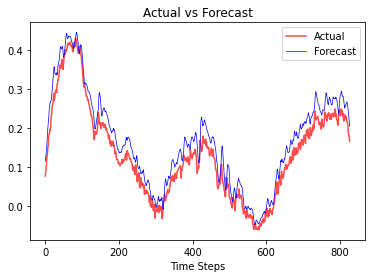

In [43]:
test_result, truth = forecast_seq(model, val_data)

plt.plot(truth, color='red', alpha=0.7)
plt.plot(test_result, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()